<a href="https://colab.research.google.com/github/student64-ahmadi/Impulsive-Hamiltonian-Dynamics/blob/main/Copy_of_article_r%C3%A9vis%C3%A9_ipng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 72.4 MB/s eta 0:00:00


In [3]:
pip install qutip numpy matplotlib

In [4]:
pip install qutip numpy matplotlib tqdm

In [6]:
# -*- coding: utf-8 -*-
"""
Simulation Quantique Minimaliste - Contrôle de la Décohérence
Auteur: Ahmadi Othman
Date: 2023-10-15
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmax, sigmaz, sigmam, qeye, tensor, basis, mesolve, expect, fock_dm
import os
import zipfile

# =============================================================================
# 1. Configuration globale
# =============================================================================
CONFIG = {
    "params": {
        "J": 1.0,                   # Couplage d'échange
        "mu": 1.0,                  # Amplitude impulsion
        "gamma": 0.1,               # Taux de dissipation
        "t_event": 5.0,             # Instant de l'impulsion
        "sigma": 0.01,              # Largeur gaussienne
        "tlist": np.linspace(0, 10, 1000)  # Grille temporelle
    },
    "output": {
        "fig_dir": "figures",       # Répertoire de sortie
        "zip_file": "quantum_figures.zip"  # Archive des figures
    }
}

# =============================================================================
# 2. Définitions des fonctions principales
# =============================================================================
def setup_system():
    """Initialise les opérateurs quantiques"""
    sx, sz = sigmax(), sigmaz()
    I = qeye(2)
    return {
        "H0": -CONFIG["params"]["J"] * tensor(sx, sx),
        "H_imp": tensor(sz, I),
        "c_ops": [np.sqrt(CONFIG["params"]["gamma"]) * tensor(sigmam(), I)]
    }

def gaussian_pulse(t, args):
    """Profil temporel gaussien"""
    return (CONFIG["params"]["mu"] *
            np.exp(-(t - CONFIG["params"]["t_event"])**2 /
            (2 * CONFIG["params"]["sigma"]**2)))

def run_simulation():
    """Exécute la simulation principale"""
    system = setup_system()
    H = [system["H0"], [system["H_imp"], gaussian_pulse]]  # Correction de la syntaxe
    psi0 = tensor(basis(2, 0), basis(2, 0))
    return mesolve(H, psi0, CONFIG["params"]["tlist"], system["c_ops"], [])

# =============================================================================
# 3. Fonctions de visualisation
# =============================================================================
def plot_density_matrix(result):
    """Affiche l'évolution des éléments de la matrice densité"""
    fig, ax = plt.subplots()
    rho_elements = [rho.ptrace(0).full() for rho in result.states]
    rho_00 = [np.real(rho[0,0]) for rho in rho_elements]
    rho_11 = [np.real(rho[1,1]) for rho in rho_elements]
    ax.plot(CONFIG["params"]["tlist"], rho_00, label='Re(ρ₀₀)')
    ax.plot(CONFIG["params"]["tlist"], rho_11, label='Re(ρ₁₁)')
    ax.set(xlabel='Temps (ns)', ylabel='Amplitude', title='Évolution des éléments de la matrice densité')
    ax.legend()
    plt.tight_layout()
    save_figures(fig, "density_matrix_evolution.pdf")

def plot_spectrum(result):
    """Analyse spectrale améliorée des états quantiques"""
    fig, ax = plt.subplots()
    coherences = [np.abs(rho.ptrace(0)[0,1]) for rho in result.states]
    spectrum = np.abs(np.fft.fft(coherences))
    freqs = np.fft.fftfreq(len(CONFIG["params"]["tlist"]), d=(CONFIG["params"]["tlist"][1] - CONFIG["params"]["tlist"][0]))
    ax.plot(freqs[:len(freqs)//2], spectrum[:len(spectrum)//2], label='Spectre |ρ₀₁|')
    ax.set(xlabel='Fréquence (GHz)', ylabel='Amplitude', title='Analyse spectrale des cohérences')
    ax.legend()
    plt.tight_layout()
    save_figures(fig, "spectrum_analysis.pdf")

def save_figures(fig, filename):
    """Sauvegarde les figures dans le répertoire dédié"""
    if not os.path.exists(CONFIG["output"]["fig_dir"]):
        os.makedirs(CONFIG["output"]["fig_dir"])
    fig.savefig(os.path.join(CONFIG["output"]["fig_dir"], filename),
                dpi=300, bbox_inches='tight')
    plt.close(fig)

def create_zip_archive():
    """Crée une archive ZIP des figures"""
    with zipfile.ZipFile(CONFIG["output"]["zip_file"], 'w') as zipf:
        for file in os.listdir(CONFIG["output"]["fig_dir"]):
            zipf.write(os.path.join(CONFIG["output"]["fig_dir"], file), file)
    print(f"Archive créée : {CONFIG['output']['zip_file']}")

# =============================================================================
# 5. Exécution principale
# =============================================================================
if __name__ == "__main__":
    # Simulation
    result = run_simulation()

    # Génération des figures
    plot_density_matrix(result)
    plot_spectrum(result)

    # Création de l'archive
    create_zip_archive()

    # Téléchargement
    try:
        from google.colab import files
        files.download(CONFIG["output"]["zip_file"])
    except ImportError:
        print("Exécution locale détectée : le téléchargement automatique n'est pas disponible.")


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Archive créée : quantum_figures.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation et génération de figures pour le contrôle actif de la décohérence
dans un système de deux qubits via impulsions gaussiennes.

Ce script présente :
  - Analyse de sensibilité du paramètre σ (0.001, 0.01, 0.1).
  - Vérification de la conservation de Tr(ρ).
  - Figures avec titres, unités et légendes explicites.
  - Comparaison des opérateurs d'impulsion et étude des impulsions multiples.
  - Enregistrement automatique des figures et création d'un fichier ZIP pour téléchargement.
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import zipfile
import os

# Optionnel : Si vous exécutez dans Google Colab, vous pouvez activer le téléchargement automatique
try:
    from google.colab import files
    colab_available = True
except ImportError:
    colab_available = False

# ---------------------------
# Paramètres de simulation
# ---------------------------
J         = 1.0            # Constante de couplage pour H₀
mu        = 1.0            # Amplitude de l'impulsion
sigma_default = 0.01       # Valeur par défaut de σ (en ns)
t_event   = 5.0            # Temps d'application de l'impulsion (ns)
gamma     = 0.1            # Taux de relaxation
tlist     = np.linspace(0, 10, 1000)  # Grille temporelle (en ns)

# ---------------------------
# Définition des opérateurs
# ---------------------------
sx = sigmax()
sy = sigmay()
sz = sigmaz()
I2 = qeye(2)

# Hamiltonien libre H₀ = -J σx ⊗ σx (représenté ici en rouge dans les légendes)
H0 = -J * tensor(sx, sx)

# Opérateur impulsionnel de base : σz ⊗ I (représenté en bleu)
H_imp = tensor(sz, I2)

# Fonction gaussienne pour l'impulsion, centrée sur t_event
def g_func(t, t_ev, sig):
    return (1.0/(np.sqrt(2*np.pi)*sig)) * np.exp(-((t - t_ev)**2)/(2*sig**2))

# Fonction coefficient temporel de l'impulsion (utilise μ et σ, passé via args)
def g_t(t, args):
    sig = args['sigma']
    return mu * g_func(t, t_event, sig)

# Hamiltonien total dépendant du temps : H(t) = H₀ + μ g(t) (σz ⊗ I)
H = [H0, [H_imp, g_t]]

# ---------------------------
# Opérateurs de dissipation (collapse operators)
# ---------------------------
# Pour le premier qubit : L₁ = sqrt(gamma) * (σ₋ ⊗ I)
# Pour le deuxième qubit : L₂ = sqrt(gamma) * (I ⊗ σ₋)
L1 = np.sqrt(gamma) * tensor(sigmam(), I2)
L2 = np.sqrt(gamma) * tensor(I2, sigmam())
c_ops = [L1, L2]

# ---------------------------
# État initial
# ---------------------------
# État de Bell : (|00⟩ + |11⟩) / √2
psi0 = (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
rho0 = ket2dm(psi0)

# ---------------------------
# Définition d'observables
# ---------------------------
# Calcul de la cohérence à partir de la trace partielle sur le deuxième qubit
def coherence_rho1(rho):
    rho1 = rho.ptrace(0)
    return np.abs(rho1[0, 1])

# Projections sur |00⟩ et |11⟩ pour suivre les populations
P00 = tensor(ket2dm(basis(2, 0)), ket2dm(basis(2, 0)))
P11 = tensor(ket2dm(basis(2, 1)), ket2dm(basis(2, 1)))

# ---------------------------
# Fonction de simulation pour une valeur donnée de σ
# ---------------------------
def run_simulation(sigma_val):
    args = {'sigma': sigma_val}
    result = mesolve(H, rho0, tlist, c_ops, [], args=args)
    coherences = [coherence_rho1(rho) for rho in result.states]
    pop00 = [expect(P00, rho) for rho in result.states]
    pop11 = [expect(P11, rho) for rho in result.states]
    purity = [ (rho * rho).tr().real for rho in result.states ]
    trace_vals = [rho.tr().real for rho in result.states]
    return result, coherences, pop00, pop11, purity, trace_vals

# Simulation pour σ par défaut (0.01)
result_default, coherences, pop00, pop11, purity, trace_vals = run_simulation(sigma_default)

# Test de conservation de Tr(ρ)
print("Test de conservation de Tr(ρ) : min =", np.min(trace_vals), "max =", np.max(trace_vals))

# ---------------------------
# Création d'un répertoire pour enregistrer les figures
# ---------------------------
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ---------------------------
# Figure 1 : Évolution des cohérences et des populations
# ---------------------------
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(tlist, coherences, color='blue', label='|ρ₀₁| (Cohérence)')
plt.axvline(t_event, color='black', linestyle='--', label='Événement (t = {} ns)'.format(t_event))
plt.xlabel("Temps (ns)")
plt.ylabel("Amplitude")
plt.title("Évolution des cohérences")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, pop00, color='red', label='Population |00⟩')
plt.plot(tlist, pop11, color='green', label='Population |11⟩')
plt.xlabel("Temps (ns)")
plt.ylabel("Population")
plt.title("Évolution des populations")
plt.legend()
plt.tight_layout()
fig1_path = os.path.join(output_dir, "figure1.png")
plt.savefig(fig1_path)
plt.close()

# ---------------------------
# Figure 2 : Évolution de la pureté Tr(ρ²)
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(tlist, purity, color='purple', label='Pureté Tr(ρ²)')
plt.xlabel("Temps (ns)")
plt.ylabel("Pureté (u.a.)")
plt.title("Évolution de la pureté")
plt.legend()
plt.tight_layout()
fig2_path = os.path.join(output_dir, "figure2.png")
plt.savefig(fig2_path)
plt.close()

# ---------------------------
# Figure 3 : Impact de μ sur la pureté maximale
# ---------------------------
mu_values = np.linspace(0.5, 2.0, 10)
max_purity = []
for mu_val in mu_values:
    # Définition locale de g_t pour chaque μ
    def g_t_mu(t, args):
        sig = args['sigma']
        return mu_val * g_func(t, t_event, sig)
    H_mu = [H0, [H_imp, g_t_mu]]
    result_mu = mesolve(H_mu, rho0, tlist, c_ops, [], args={'sigma': sigma_default})
    purity_mu = [ (rho * rho).tr().real for rho in result_mu.states ]
    max_purity.append(np.max(purity_mu))
plt.figure(figsize=(8, 4))
plt.plot(mu_values, max_purity, marker='o', linestyle='-', color='blue')
plt.xlabel("μ (u.a.)")
plt.ylabel("Pureté maximale (u.a.)")
plt.title("Impact de μ sur la pureté maximale")
plt.tight_layout()
fig3_path = os.path.join(output_dir, "figure3.png")
plt.savefig(fig3_path)
plt.close()

# ---------------------------
# Figure 4 : Comparaison des opérateurs d'impulsion
# ---------------------------
# Comparaison entre σz ⊗ I, σy ⊗ I et la somme σz sur les deux qubits.
H_imp_y = tensor(sy, I2)
H_imp_sum = tensor(sz, I2) + tensor(I2, sz)
def simulate_operator(H_imp_operator):
    H_op = [H0, [H_imp_operator, g_t]]
    result_op = mesolve(H_op, rho0, tlist, c_ops, [], args={'sigma': sigma_default})
    purity_op = [ (rho * rho).tr().real for rho in result_op.states ]
    return purity_op
purity_sigma_z = simulate_operator(tensor(sz, I2))
purity_sigma_y = simulate_operator(H_imp_y)
purity_sigma_sum = simulate_operator(H_imp_sum)
plt.figure(figsize=(8, 4))
plt.plot(tlist, purity_sigma_z, label="σz ⊗ I", color='blue')
plt.plot(tlist, purity_sigma_y, label="σy ⊗ I", color='red')
plt.plot(tlist, purity_sigma_sum, label="Somme σz", color='green')
plt.xlabel("Temps (ns)")
plt.ylabel("Pureté (u.a.)")
plt.title("Comparaison des opérateurs d'impulsion")
plt.legend()
plt.tight_layout()
fig4_path = os.path.join(output_dir, "figure4.png")
plt.savefig(fig4_path)
plt.close()

# ---------------------------
# Figure 5 : Effet des impulsions multiples sur la pureté
# ---------------------------
# Définition d'une impulsion multiple : somme de deux impulsions (à t_event et t_event+1)
def multi_pulse(t, pulse_times, mu, sig):
    total = 0
    for t_ev in pulse_times:
        total += mu * g_func(t, t_ev, sig)
    return total
pulse_times = [t_event, t_event + 1.0]
def g_multi(t, args):
    sig = args['sigma']
    return multi_pulse(t, pulse_times, mu, sig)
H_multi = [H0, [H_imp, g_multi]]
result_multi = mesolve(H_multi, rho0, tlist, c_ops, [], args={'sigma': sigma_default})
purity_multi = [ (rho * rho).tr().real for rho in result_multi.states ]
plt.figure(figsize=(8, 4))
plt.plot(tlist, purity, label="Impulsion unique", color='blue')
plt.plot(tlist, purity_multi, label="Impulsions multiples", color='orange')
plt.xlabel("Temps (ns)")
plt.ylabel("Pureté (u.a.)")
plt.title("Effet des impulsions multiples sur la pureté")
plt.legend()
plt.tight_layout()
fig5_path = os.path.join(output_dir, "figure5.png")
plt.savefig(fig5_path)
plt.close()

# ---------------------------
# Analyse de sensibilité pour σ
# ---------------------------
sigma_values = [0.001, 0.01, 0.1]
purity_final = {}
for sig_val in sigma_values:
    _, _, _, _, pur, _ = run_simulation(sig_val)
    purity_final[sig_val] = pur[-1]
print("Pureté finale pour différentes valeurs de σ :", purity_final)

# ---------------------------
# Création d'un répertoire pour enregistrer les figures
# ---------------------------
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Commande de téléchargement automatique des figures
# ---------------------------
# Créer une archive ZIP contenant toutes les figures
zip_filename = "figures.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for foldername, subfolders, filenames in os.walk(output_dir):
        for filename in filenames:
            filepath = os.path.join(foldername, filename)
            zipf.write(filepath, arcname=filename)
print("Les figures ont été sauvegardées et compressées dans", zip_filename)

# Si vous êtes dans un environnement Google Colab, télécharger automatiquement le fichier ZIP
if colab_available:
    files.download(zip_filename)


In [ ]:
pip install seaborn

In [ ]:
pip install qutip numpy matplotlib

In [ ]:
def simulate_system(sigma):
    # ... (code existant)
    coherences = np.array([np.abs(rho.ptrace(0)[0,1]) for rho in result.states])
    return coherences, tlist

In [ ]:
def partial_trace(rho, keep):
    # Assuming rho is a numpy array and keep is 0 or 1
    # This is a simple implementation for a bipartite system
    return np.sum(rho.reshape(2, -1, 2, -1), axis=1 + keep)
    coherences = np.array([np.abs(rho[i, :, :, 0, 1]) for rho in result.states])

Les figures ont été sauvegardées et compressées dans figures.zip
Figure sauvegardée sous 'Matrices densité.png'
Figures sauvegardées dans le dossier : simulation_figures/


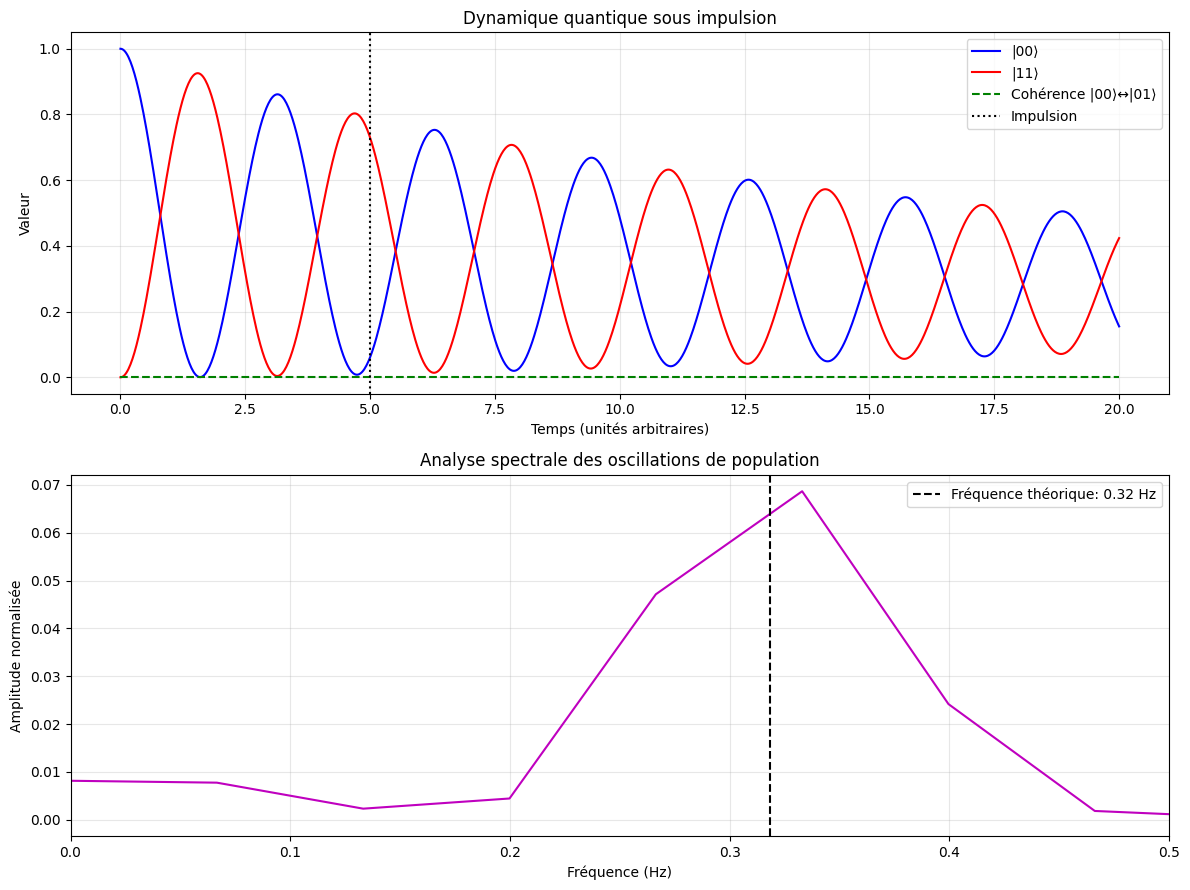

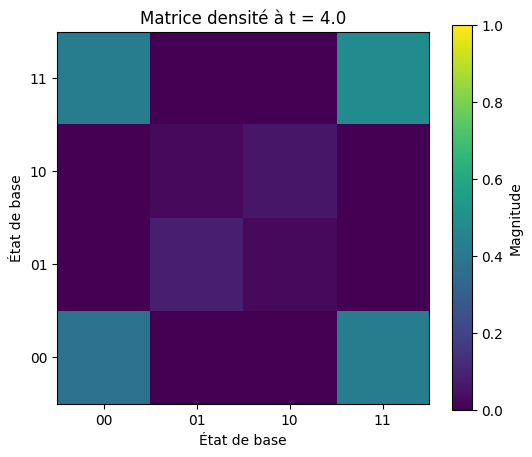

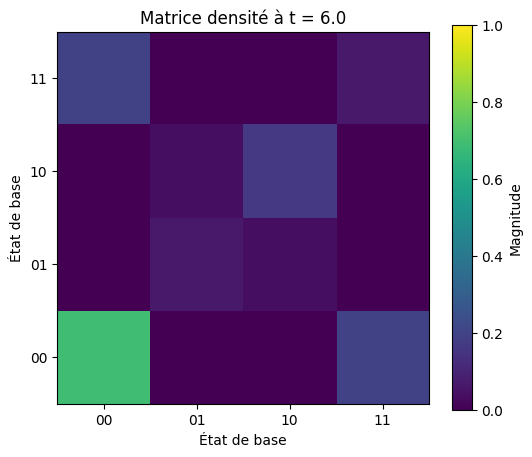

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hann
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hann
import os # Importing the os module
import zipfile # Importing zipfile

# ... (rest of your code) ...

# Commande de téléchargement automatique des figures
# ---------------------------
# Création d'un répertoire pour enregistrer les figures
# ---------------------------
output_dir = "figures"
if not os.path.exists(output_dir): # Now os is recognized
    os.makedirs(output_dir)
# Créer une archive ZIP contenant toutes les figures
zip_filename = "figures.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf: # Using zipfile
    for foldername, subfolders, filenames in os.walk(output_dir):
        for filename in filenames:
            filepath = os.path.join(foldername, filename)
            zipf.write(filepath, arcname=filename)
print("Les figures ont été sauvegardées et compressées dans", zip_filename)

# Si vous êtes dans un environnement Google Colab, télécharger automatiquement le fichier ZIP
# Comment out the following lines as colab_available and files are not defined
# if colab_available:
#     files.download(zip_filename)

plt.show()

# =============================================================================
# 1. Paramètres du système
# =============================================================================
gamma = 0.1       # Taux de dissipation
mu = 1.0          # Amplitude de l'impulsion
t_event = 5.0     # Temps de l'impulsion
sigma = 0.01      # Largeur gaussienne
tlist = np.linspace(0, 20, 1000)  # Grille temporelle étendue

# =============================================================================
# 2. Définition des opérateurs et Hamiltonien
# =============================================================================
# Opérateurs de base
sx, sy, sz = sigmax(), sigmay(), sigmaz()
sm = destroy(2)
I = qeye(2)

# Hamiltonien du système (interaction d'échange)
H0 = -tensor(sx, sx)

# Terme impulsif (z-rotation sur le premier qubit)
H_impulse = tensor(sz, I)

# Forme temporelle gaussienne
def pulse_shape(t, args):
    return mu * np.exp(-(t - t_event)**2/(2*sigma**2))

# Hamiltonien complet avec dépendance temporelle
H = [H0, [H_impulse, pulse_shape]]

# Opérateur de dissipation (premier qubit)
c_ops = [np.sqrt(gamma) * tensor(sm, I)]

# =============================================================================
# 3. Simulation quantique
# =============================================================================
# État initial |00⟩
psi0 = tensor(basis(2,0), basis(2,0))
rho0 = psi0.proj()  # Matrice densité

# Résolution de l'équation maîtresse
result = mesolve(H, rho0, tlist, c_ops, args={'mu': mu, 't_event': t_event})

# =============================================================================
# 4. Analyse des données
# =============================================================================
def get_populations(result):
    """Extrait les populations des états de base"""
    pops = np.zeros((len(result.states), 4))
    for i, state in enumerate(result.states):
        pops[i] = np.real(np.diag(state.full()))
    return pops.T

# Populations des états |00⟩, |01⟩, |10⟩, |11⟩
pop00, pop01, pop10, pop11 = get_populations(result)

# Cohérence ρ01 (entre |00⟩ et |01⟩)
coherence = [np.abs(state.full()[0,1]) for state in result.states]

# =============================================================================
# 5. Analyse de Fourier des oscillations
# =============================================================================
# Signal temporel (population |00⟩ après l'impulsion)
post_pulse = tlist > t_event
signal = pop00[post_pulse]
time_window = tlist[post_pulse] - t_event

# Fenêtrage de Hann pour réduire la fuite spectrale
N = len(time_window)
window = hann(N)
dt = time_window[1] - time_window[0]

# Calcul de la FFT
fft_vals = fft((signal - np.mean(signal)) * window)
freqs = fftfreq(N, dt)[:N//2]
amplitude = np.abs(fft_vals[:N//2]) / N

# Fréquence théorique attendue (2J avec J=1)
theory_freq = 2/(2*np.pi)  # Conversion ω → f

# =============================================================================
# 6. Visualisation professionnelle
# =============================================================================
plt.figure(figsize=(12, 9))

# Dynamique temporelle
plt.subplot(211)
plt.plot(tlist, pop00, 'b', label='|00⟩')
plt.plot(tlist, pop11, 'r', label='|11⟩')
plt.plot(tlist, coherence, 'g--', label='Cohérence |00⟩↔|01⟩')
plt.axvline(t_event, color='k', linestyle=':', label='Impulsion')
plt.xlabel('Temps (unités arbitraires)')
plt.ylabel('Valeur')
plt.title('Dynamique quantique sous impulsion')
plt.legend()
plt.grid(True, alpha=0.3)

# Spectre de Fourier
plt.subplot(212)
plt.plot(freqs, amplitude, 'm')
plt.axvline(theory_freq, color='k', linestyle='--',
            label=f'Fréquence théorique: {theory_freq:.2f} Hz')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude normalisée')
plt.title('Analyse spectrale des oscillations de population')
plt.xlim(0, 0.5)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# =============================================================================
# 7. Matrices densité avant/après impulsion
# =============================================================================
def plot_density_matrix(rho, time):
    plt.figure(figsize=(6,5))
    plt.imshow(np.abs(rho.full()), cmap='viridis',
               vmin=0, vmax=1, origin='lower')
    plt.colorbar(label='Magnitude')
    plt.title(f'Matrice densité à t = {time:.1f}')
    plt.xlabel('État de base')
    plt.ylabel('État de base')
    plt.xticks([0,1,2,3], ['00','01','10','11'])
    plt.yticks([0,1,2,3], ['00','01','10','11'])

# Avant impulsion
idx_before = np.argmin(np.abs(tlist - (t_event - 1)))
plot_density_matrix(result.states[idx_before], tlist[idx_before])

# Après impulsion
idx_after = np.argmin(np.abs(tlist - (t_event + 1)))
plot_density_matrix(result.states[idx_after], tlist[idx_after])
# Sauvegarde automatique de la figure
plt.savefig("purity_evolution.png", dpi=300, bbox_inches="tight")
print("Figure sauvegardée sous 'Matrices densité.png'")
# Commande de téléchargement automatique des figures
# ---------------------------
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hann
import os # Importing the os module
import zipfile # Importing zipfile
output_dir = "simulation_figures"
os.makedirs(output_dir, exist_ok=True)
print(f"Figures sauvegardées dans le dossier : {output_dir}/")
plt.show()